# **Import library and Mount drive**

In [2]:
!apt-get install -y libsndfile1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-7ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.


In [3]:
!pip install pydub
!pip install xgboost
!pip install catboost

In [6]:
import xgboost as xgb
import pandas as pd
import numpy as np
import catboost as cb
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import lightgbm as lgb
import tensorflow as tf
from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

import librosa
import os
from pydub import AudioSegment
import librosa.display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Turn all Audio file to 3 second long**

In [5]:
main_dir = '/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24'

In [ ]:
def cut_audio_to_3s(input_folder):
    for folder_name in os.listdir(main_dir):
        folder_path = os.path.join(main_dir, folder_name)
        # Iterate through each audio file in the subfolder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav') or file_name.endswith('.mp3'):
                # Load the audio file
                input_path = os.path.join(folder_path, file_name)
                try:
                    audio = AudioSegment.from_file(input_path)
                    if len(audio) < 3000:
                        silence_duration = 3000 - len(audio)
                        silence = AudioSegment.silent(duration=silence_duration)
                        three_sec_audio = audio + silence
                    else:
                        # Truncate the audio to 3 seconds
                        three_sec_audio = audio[:3000]

                    # Save the 3-second audio to the output folder
                    three_sec_audio.export(input_path, format="wav")

                except Exception as e:
                    print(f"Error processing file: {input_path}")
                    print(e)
                    # Use ffmpeg to get more detailed information
                    result = subprocess.run(['ffmpeg', '-i', input_path], stderr=subprocess.PIPE)
                    print(result.stderr.decode('utf-8'))  # Print ffmpeg's error output

cut_audio_to_3s(main_dir)

# **Take sound data from folder**

In [6]:
def label_from_folder(file_name):
    string = file_name
    # Split the string by hyphen
    numbers = string.split('-')
    # Access the third number (index 2)
    third_number = numbers[2]

    if '01' in third_number:
        return 'Neutral'
    elif '02' in third_number:
        return 'Calm'
    elif '03' in third_number:
        return 'Happy'
    elif '04' in third_number:
        return 'Sad'
    elif '05' in third_number:
        return 'Angry'
    elif '06' in third_number:
        return 'Fearful'
    elif '07' in third_number:
        return 'Disgust'
    elif '08' in third_number:
        return 'Surprised'
    else:
        return 'Unknown'

# Dictionary to store file paths and their corresponding labels
data = {'file_path': [], 'label': []}

# Iterate through each subfolder
for folder_name in os.listdir(main_dir):
    folder_path = os.path.join(main_dir, folder_name)
    # Iterate through each audio file in the subfolder
    for file_name in os.listdir(folder_path):
      if file_name.endswith('.wav') or file_name.endswith('.mp3'):
        label = label_from_folder(file_name)
        file_path = os.path.join(folder_path, file_name)
        data['file_path'].append(file_path)
        data['label'].append(label)

# Convert to DataFrame
df = pd.DataFrame(data)

In [7]:
df

,file_path,label
0,/content/drive/MyDrive/Sound_Expression/audio_...,Neutral
1,/content/drive/MyDrive/Sound_Expression/audio_...,Calm
2,/content/drive/MyDrive/Sound_Expression/audio_...,Neutral
3,/content/drive/MyDrive/Sound_Expression/audio_...,Calm
4,/content/drive/MyDrive/Sound_Expression/audio_...,Happy
...,...,...
1434,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised
1435,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised
1436,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised
1437,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised


# **Save output CSV to folder And Plot example**

In [ ]:
output_file_path = '/content/drive/MyDrive/Sound_Expression/audio_labels.csv'
df.to_csv(output_file_path, index=False)

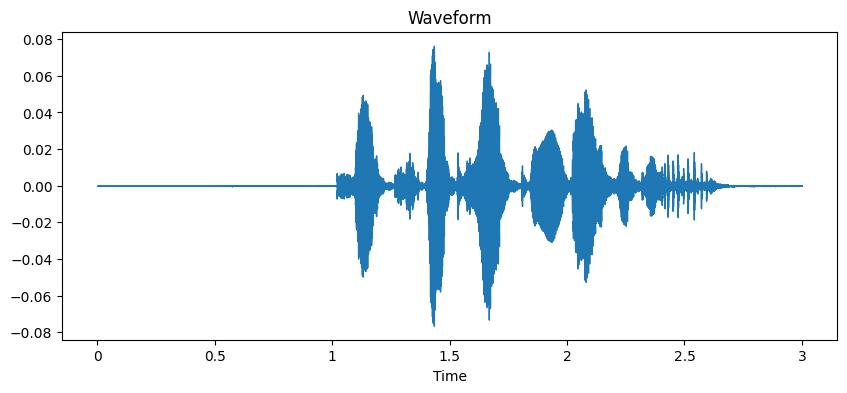

<ipython-input-22-efbc979e0c04>:12: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.

  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


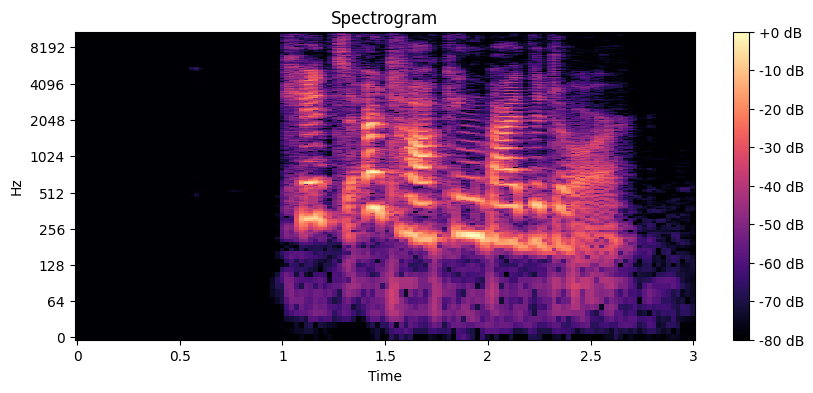

In [ ]:
# Load an example audio file
example_file = os.path.join(main_dir, '/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-01-02.wav')
y, sr = librosa.load(example_file)

# Display waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

# Display spectrogram
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

# **Data Extraction**

In [ ]:
def extract_mfcc(file_path, n_mfcc=40):
    frame_size = 400  # 25 ms at 16 kHz
    hop_length = 200  # 12.5 ms at 16 kHz
    X, srr = librosa.load(file_path, sr=None)
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=srr, n_mfcc=n_mfcc, n_fft=frame_size, hop_length=hop_length).T, axis=0)
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
    return mfccs, mfcc_delta, mfcc_delta2

In [ ]:
sample="/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24/Actor_24/03-01-01-01-01-02-24.wav"
mfccs, mfcc_delta, mfcc_delta2 = extract_mfcc(sample, n_mfcc=40)
mfcc_delta2.shape

(40,)

In [ ]:
def flatten_features(mfccs,mfcc_delta,mfcc_delta2):
    mfccs=mfccs.flatten()
    mfcc_delta=mfcc_delta.flatten()
    mfcc_delta2=mfcc_delta2.flatten()
    # Concatenate and flatten the features
    combined_features = np.concatenate((mfccs,mfcc_delta,mfcc_delta2), axis=0)
    return combined_features

In [ ]:
sample="/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24/Actor_24/03-01-01-01-01-02-24.wav"
mfccs, mfcc_delta, mfcc_delta2= extract_mfcc(sample, n_mfcc=40)
m=flatten_features(mfccs,mfcc_delta,mfcc_delta2)
print(m.shape)

(120,)


In [ ]:
m

array([-8.7880615e+02,  4.2505436e+01, -2.6118071e+01,  2.3557870e+00,
        4.2406754e+00,  9.6034327e+00, -7.9665041e+00, -2.2624679e+00,
       -1.1070573e+01, -6.4312797e+00,  9.9521285e-01, -1.1634970e+00,
       -4.1464515e+00, -3.5081563e+00,  4.7739869e-01, -2.3875217e+00,
       -2.9893005e+00,  2.5618367e+00, -1.8435050e+00, -2.1322784e+00,
       -1.9781044e+00, -4.5108538e+00, -4.5266266e+00, -5.6378183e+00,
       -3.9493055e+00, -9.3365371e-01, -1.6850389e+00, -6.6577905e-01,
       -3.8034265e+00, -5.2629948e+00, -1.5976372e+00,  9.9219120e-01,
        3.2737162e+00,  2.2692194e+00, -1.0435627e+00, -3.9194314e+00,
       -6.4876208e+00, -4.1558371e+00, -3.8701537e+00, -3.4847658e+00,
        5.6336491e+01,  5.6336491e+01,  5.6336491e+01,  5.6336491e+01,
        5.6336491e+01, -2.8674676e+00,  6.6005892e-01, -9.8311692e-01,
       -8.6824459e-01, -4.4537452e-01,  8.1924284e-01,  5.8080471e-01,
        6.8460125e-01,  4.3657878e-01,  5.4267768e-02,  1.9511667e-01,
      

In [ ]:
output_file_path = '/content/drive/MyDrive/Sound_Expression/features_extraction.csv'
m=np.zeros((1439,120))
df2=pd.DataFrame(m)
df2.to_csv(output_file_path, index=False)

In [ ]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def extract_features_to_csv(file_paths, labels, output_csv, n_mfcc=40, max_length=120):
    with open(output_csv, 'w') as f:
        # Write header
        header = ['File'] + [f'Feature_{i}' for i in range(max_length)] + ['Label']
        f.write(','.join(header) + '\n')

        for i, file_path in enumerate(file_paths):
            # Extract features
            mfccs,mfcc_delta,mfcc_delta2= extract_mfcc(file_path, n_mfcc=n_mfcc)
            flattened_features = flatten_features(mfccs,mfcc_delta,mfcc_delta2)
            label = labels[i]

            # Write row
            row = [f'File_{i}'] + flattened_features.tolist() + [label]
            f.write(','.join(map(str, row)) + '\n')

file_paths = df.iloc[:, 0].values
labels = df.iloc[:, -1].values
output_csv = '/content/drive/MyDrive/Sound_Expression/features_extraction.csv'
extract_features_to_csv(file_paths, labels, output_csv, n_mfcc=40, max_length=120)

/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [7]:
df5=pd.read_csv('/kaggle/input/cccccsad/features_extraction.csv')

In [8]:
df5.head()

,File,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_111,Feature_112,Feature_113,Feature_114,Feature_115,Feature_116,Feature_117,Feature_118,Feature_119,Label
0,File_0,-899.346069,32.531887,-33.817184,7.570754,6.082529,10.584245,-11.436819,-0.961268,-10.697849,...,-0.412477,-0.999853,-0.893842,-0.398864,0.369642,0.369642,0.369642,0.369642,0.369642,Neutral
1,File_1,-1000.576111,21.916056,-21.368122,12.250976,3.601930,11.353006,-5.412685,-0.157168,-10.195058,...,-0.345530,-0.754515,-0.649922,-0.291472,0.256190,0.256190,0.256190,0.256190,0.256190,Calm
2,File_2,-903.146240,26.399696,-28.600018,8.960649,3.997856,12.410592,-11.323064,-0.321365,-12.953524,...,-0.449907,-0.949165,-0.743547,-0.275729,0.371048,0.371048,0.371048,0.371048,0.371048,Neutral
3,File_3,-980.440002,20.740654,-25.198479,13.071759,1.060415,14.652720,-8.243542,-0.700215,-11.286477,...,-0.374450,-0.890915,-0.801550,-0.344956,0.303733,0.303733,0.303733,0.303733,0.303733,Calm
4,File_4,-762.365051,37.114128,-30.194338,4.168355,7.450680,7.960943,-10.446024,-1.393561,-8.528953,...,-0.465276,-0.887537,-0.700382,-0.214717,0.332603,0.332603,0.332603,0.332603,0.332603,Happy


In [ ]:
y=df5.iloc[:,-1]

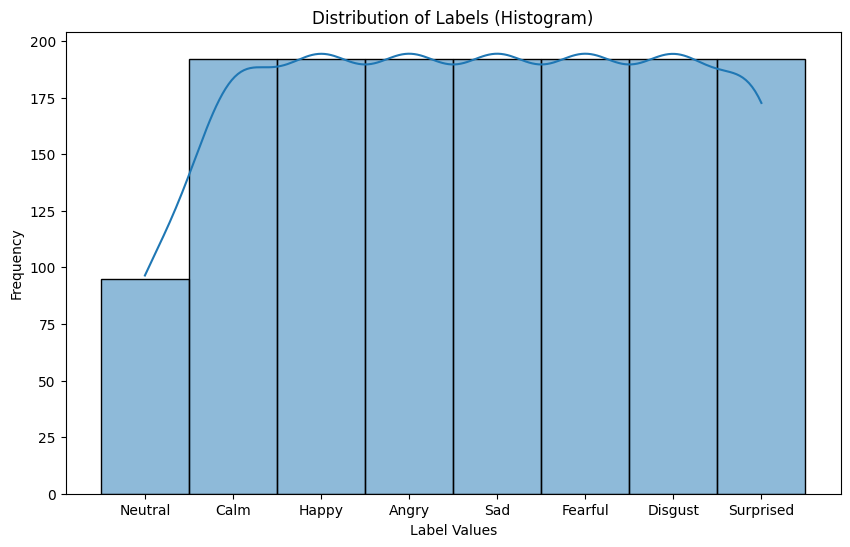

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=True)
plt.xlabel('Label Values')
plt.ylabel('Frequency')
plt.title('Distribution of Labels (Histogram)')
plt.show()

# **Others Features we can considered when the model are not satisfy**

# Extract chroma features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Extract spectral contrast
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

# Extract spectral centroid
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

# Extract zero-crossing rate
zero_crossing_rate = librosa.feature.zero_crossing_rate(y)

# Extract root mean square energy
rms = librosa.feature.rms(y=y)

# Extract mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)


In [ ]:
# Load audio file
# y, sr = librosa.load('your_audio_file.wav', sr=None)

# Extract MFCCs
# mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Extract delta and delta-delta coefficients
# mfcc_delta = librosa.feature.delta(mfcc)
# mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

# Extract chroma features
# chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Extract spectral contrast
# spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

# Extract spectral centroid
# spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

# Extract zero-crossing rate
# zero_crossing_rate = librosa.feature.zero_crossing_rate(y)

# Extract root mean square energy
# rms = librosa.feature.rms(y=y)

# Extract mel spectrogram
# mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Combine all features
# features = np.concatenate((mfcc, mfcc_delta, mfcc_delta2, chroma, spectral_contrast,
#                            spectral_centroid, zero_crossing_rate, rms, mel_spectrogram), axis=0)

# Shape of features
# print("Shape of combined features: ", features.shape)

# **Split data frame to smaller data (X,y)**

In [22]:
X=df5.iloc[:,1:-1]
y=df5.iloc[:,-1]

In [23]:
# Encode string class values as integers to avoid errors in newer versions of XGBoost
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
y = label_encoder.transform(y)

In [25]:
X=np.array(X)
y=np.array(y)

In [26]:
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=104,
                                   test_size=0.25,
                                   shuffle=True)

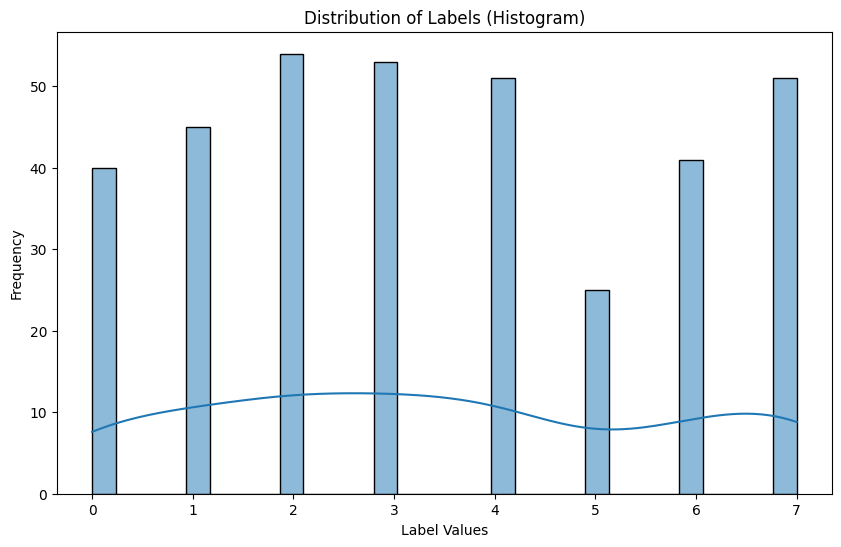

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=30, kde=True)
plt.xlabel('Label Values')
plt.ylabel('Frequency')
plt.title('Distribution of Labels (Histogram)')
plt.show()

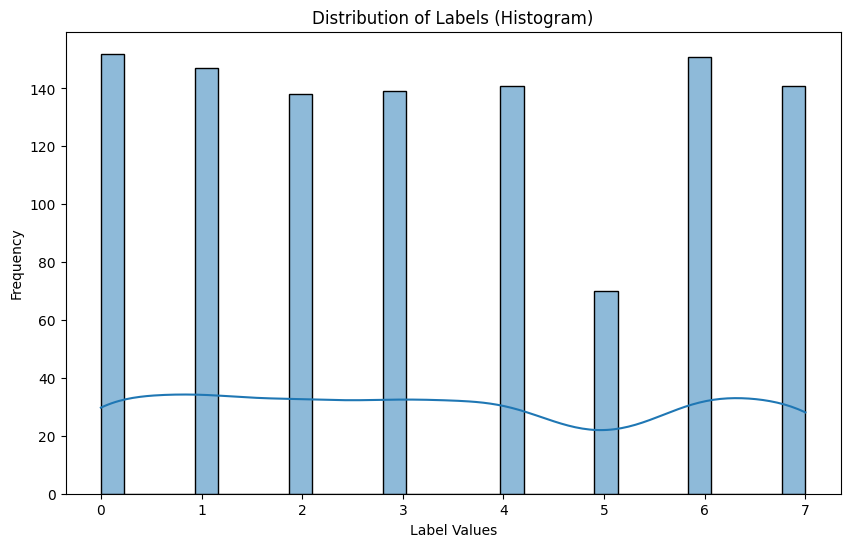

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=30, kde=True)
plt.xlabel('Label Values')
plt.ylabel('Frequency')
plt.title('Distribution of Labels (Histogram)')
plt.show()

In [ ]:
print(X.shape)
print(y.shape)
print(X[1,-1])

(1439, 40)

(1439,)

2.248993158340454


## **LSTM Model**

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [26]:
print(X_train.shape)

(1079, 120)


In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [18]:
model = Sequential()

# Adjusted input_shape to match the reshaped input data
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=8, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 120, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,312 (462.16 KB)

 Trainable params: 118,312 (462.16 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# One-hot encode the target variable
y_train = to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1595 - loss: 2.0776 - val_accuracy: 0.1250 - val_loss: 2.0749
Epoch 2/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1194 - loss: 2.0630 - val_accuracy: 0.1574 - val_loss: 2.0700
Epoch 3/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1138 - loss: 2.0740 - val_accuracy: 0.1898 - val_loss: 2.0521
Epoch 4/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1556 - loss: 2.0289 - val_accuracy: 0.2361 - val_loss: 1.9362
Epoch 5/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2208 - loss: 1.9870 - val_accuracy: 0.2407 - val_loss: 1.9206
Epoch 6/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2470 - loss: 1.9506 - val_accuracy: 0.2361 - val_loss: 1.9003
Epoch 7/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2258 - loss: 1.9250 - val_accuracy: 0.2454 - val_loss: 1.9095
Epoch 8/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2206 - loss: 1.8947 - val_accuracy: 0.